<h1> Better identification of SCN neurons subtypes following filtering of cyclic process</h1>
<h3>The scn neurons dataset was collected from multiple time points. Therefore, it is challenging to identify neurons subtypes.</h3>
We use here numba library.to accelarate the computation.

In [49]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import pandas as pd
from algorithms import *
from data_gen import *
from spectrum_gen import *
from visualizations import *
from analysis import *
import numpy as np
from numba import jit
from scipy.stats import entropy

@jit(nopython=True)
def myclip(F):
    """Standard clamping of a value into a fixed range (in this case 0 to
    1)

    Parameters
    ----------
    val: float
        The value to be clamped.

    Returns
    -------
    The clamped value, now fixed to be in the range -4.0 to 4.0.
    """
    for i in range(F.shape[0]):
        for j in range(F.shape[1]):
            val = F[i,j]
            if val >= 1:
                F[i,j]=1
            elif val <= 0:
                F[i,j]=0
    return F

@jit(nopython=True, parallel=True)
def fAndG_full_jit(A, B, V, alpha, regu_norm='L1'):
    '''
    :param A: Gene expression matrix
    :param B: filtering matrix
    :param V: spectral matrix
    :param alpha: correlation between neighbors
    :return:projection over theoretic spectrum and gradient according to 'B'
    '''
    if regu_norm=='L1':
        T_0 = (A * B)
        t_1 = np.linalg.norm(B, 1)
        functionValue = (np.trace((((V.T).dot(T_0)).dot(T_0.T)).dot(V)) - (alpha * t_1))
        gradient = ((2 * (((V).dot(V.T)).dot(T_0) * A)) - ((alpha ) * np.sign(B)))
    else:
        T_0 = (A * B)
        t_1 = np.linalg.norm(A * B, 'fro')
        functionValue = (np.trace((((V.T).dot(T_0)).dot(T_0.T)).dot(V)) - (alpha * t_1))
        gradient = ((2 * (((V).dot(V.T)).dot(T_0) * A))- ((alpha / t_1) * B))
    return functionValue, gradient

@jit(nopython=True, parallel=True)
def filtering_cyclic_boosted_inner(A,F,V, regu=0.1, iterNum=300, verbosity = 5 , epsilon=10e-3):
    ''' Filtering of cyclic signal
    :param A: Gene expression matrix (reordered according to cyclic ordering)
    :param regu: regularization coefficient
    :param iterNum: iteration number
    :return: filtering matrix
    '''
    print("starting filtering")
    V = V.T
    j = 0
    epsilon_t = epsilon
    tmp_value=0
    while j < iterNum:
        if j % verbosity == 1:
            print("Iteration number: " + str(j))# + " functio value= " +str(tmp_value))
            print(tmp_value)
        epsilon_t *= 0.995
        tmp_value, grad = fAndG_full_jit(A=A, B=F, V=V, alpha=regu)
        F = F - epsilon_t * grad
        F = myclip(F)
        j += 1
    return F

def filtering_cyclic_boosted(A, regu=0.1, iterNum=300, verbosity = 2 , epsilon=10e-3, optimize_alpha=True):
    ''' Filtering of cyclic signal
    :param A: Gene expression matrix (reordered according to cyclic ordering)
    :param regu: regularization coefficient
    :param iterNum: iteration number
    :return: filtering matrix
    '''
    F = np.ones(A.shape)
    A = cell_normalization(A)
    V = ge_to_spectral_matrix(A , optimize_alpha=optimize_alpha)
    F = filtering_cyclic_boosted_inner(A,F, V,regu,iterNum,verbosity=verbosity,epsilon=epsilon)
    return F

def count_hours_per_cluster(adata, nclusters=10):
    hours_array = np.zeros((6,nclusters))
    ct_list = ['02','06','10','14','18','22']
    var_list = [ ]
    ent_list = [ ]
    angles = (np.array(range(6))*2*np.pi)/6
    for i in range(nclusters):
        adata_tmp = (adata[adata.obs['leiden'].isin([str(i)])])
        print("Cluster " +str(i) + " contains " +str(adata_tmp.X.shape[0]) + " samples")
        for j in range(6):
            adata_tmp_2 = (adata_tmp[adata_tmp.obs['CT'].isin([ct_list[j]])])
            hours_array[j,i] = adata_tmp_2.X.shape[0]
        hours_array[:,i] = hours_array[:,i]/hours_array[:,i].sum()
        var_list.append(circular_mean(angles,hours_array[:,i])[1])
        ent_list.append(entropy(hours_array[:,i]))
    hours_array = hours_array.T
    df = pd.DataFrame({'02': hours_array[:,0], '06': hours_array[:,1], '10': hours_array[:,2] ,
                       '14':hours_array[:,3],'18':hours_array[:,4],'22':hours_array[:,5]})
    sns.set(font_scale=1.2)
    cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
    ax = sns.heatmap(df, annot=hours_array, vmin=0, vmax=0.4,cmap ='RdBu_r'
    )
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=17)
    plt.title('Percentage of cells from each timepoint')
    plt.ylabel("Leiden", fontsize=20)
    plt.xlabel("Timepoint", fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=12)

    plt.show(
    )
    var_list = np.array(var_list)
    ent_list = np.array(ent_list)
    print("Mean variance: " +str(var_list.mean()))
    print("Mean entropy: " +str(ent_list.mean()))
    pass

In [2]:
adata =  read_all_scn()
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)


/Users/jonathankarin/.conda/envs/project/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'CT' as categorical


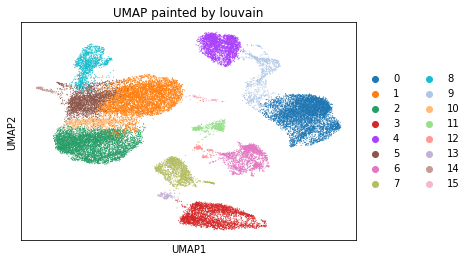

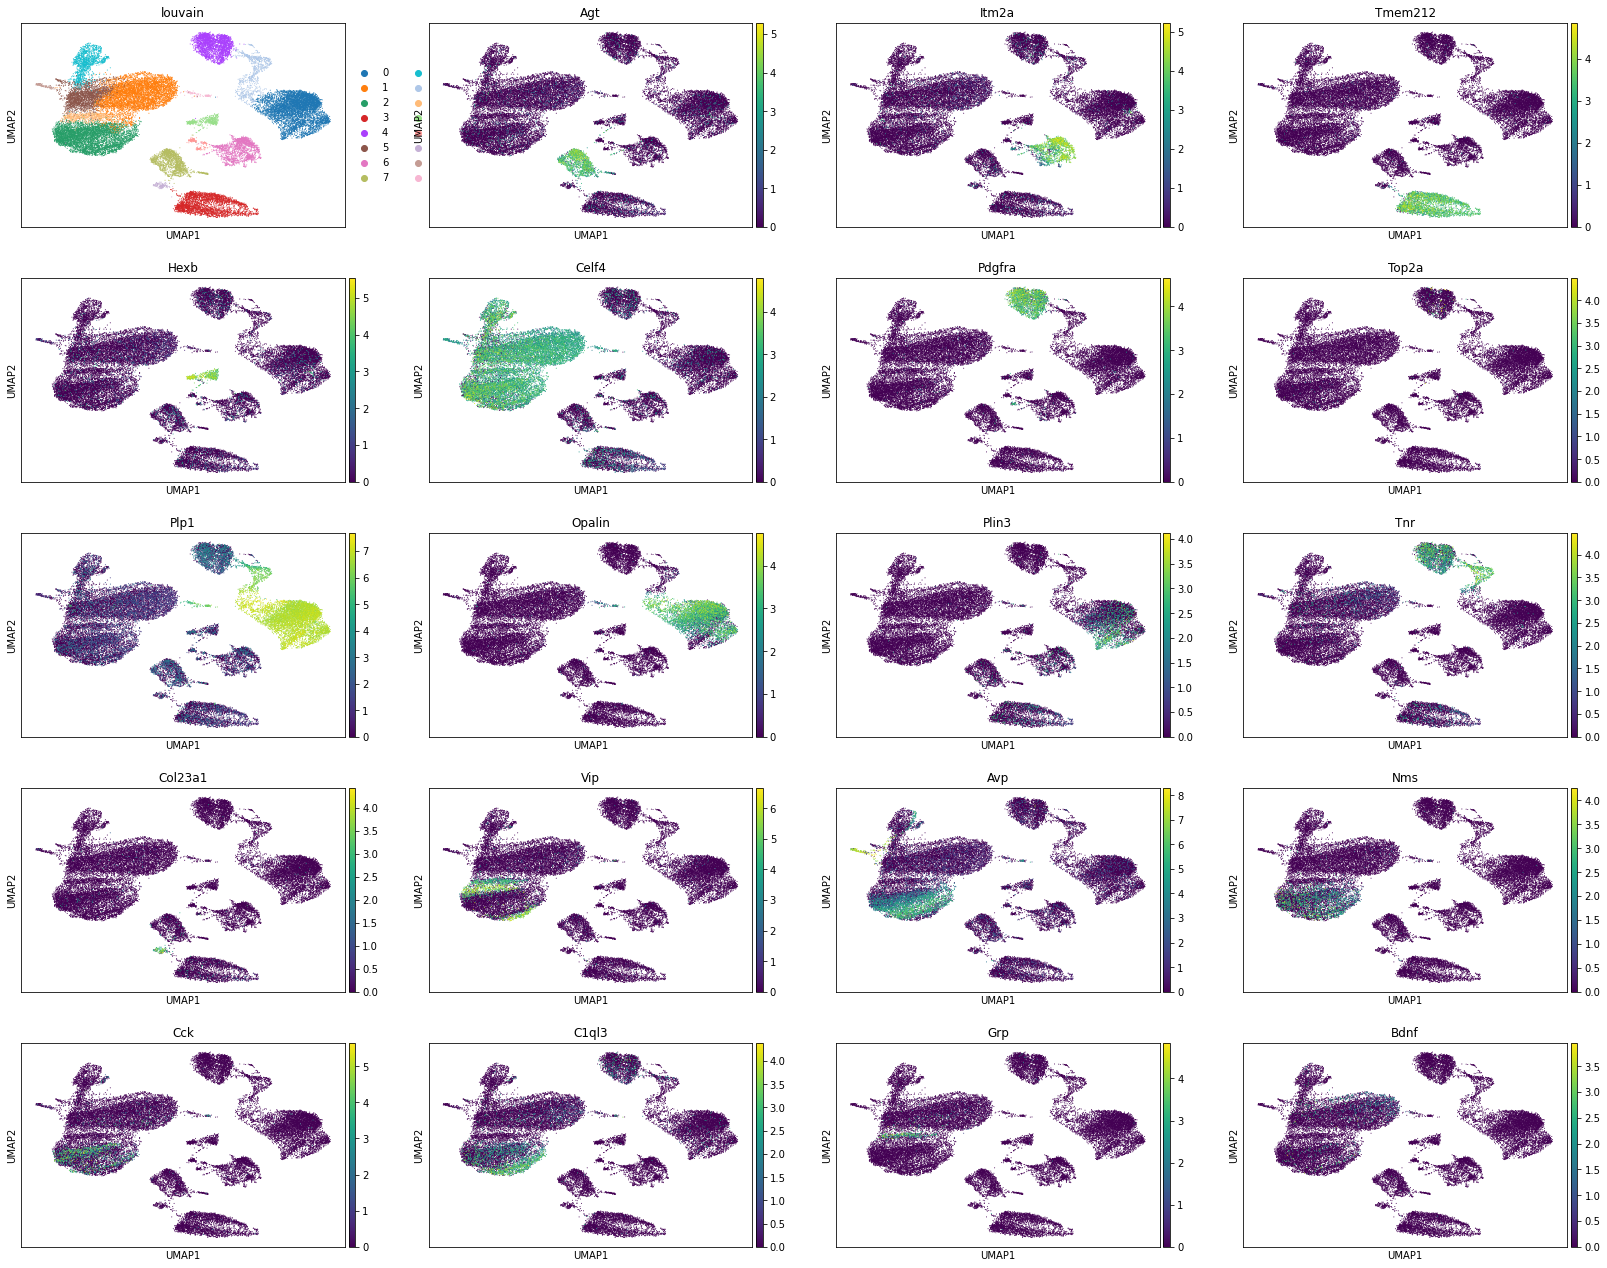

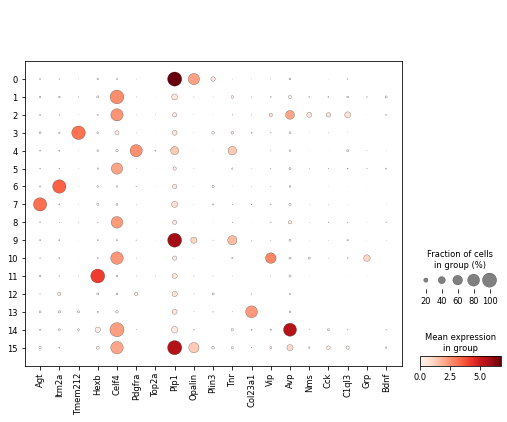

In [3]:
sc.tl.louvain(adata, resolution=0.5)
sc.tl.umap(adata)
sc.pl.umap(adata, color='louvain' , title=("UMAP painted by louvain"))
marker_genes = ['Agt', 'Itm2a','Tmem212','Hexb','Celf4','Pdgfra','Top2a','Plp1','Opalin','Plin3','Tnr','Col23a1','Vip','Avp','Nms','Cck','C1ql3','Grp','Bdnf']
sc.pl.umap(adata, color=['louvain']+marker_genes)
sc.pl.dotplot(adata, marker_genes, groupby='louvain')

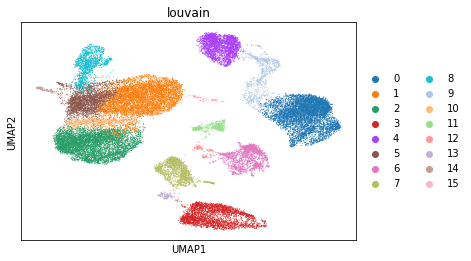

In [4]:
sc.pl.umap(adata, color=['louvain'])

In [5]:
new_cluster_names = [
    'Oligodendrocytes1',
    'Neurons1',
    'Neurons2',
    'Ependymal',
    'NG2',
    'Neurons3',
    'Endothelial',
    'Astrocytes',
    'Neurons4',
    'Oligodendrocytes2',
    'Neurons5',
    'Microglia',
    'not_real',
    'Tanycytes',
    'Neurons6',
    'Oligodendrocytes3']
adata.rename_categories('louvain', new_cluster_names)


/Users/jonathankarin/.conda/envs/project/lib/python3.8/site-packages/anndata/_core/anndata.py:1155: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  self.obs[key].cat.rename_categories(categories, inplace=True)


In [7]:
cluster_list = [
    'Neurons1',
    'Neurons2',
    'Neurons3',
    'Neurons4',
    'Neurons5',
    'Neurons6']

adata_neurons = (adata[adata.obs['louvain'].isin(cluster_list)])
sc.pp.highly_variable_genes(adata_neurons, n_top_genes=1000)
adata_neurons = sort_data_crit(adata=adata_neurons.copy(), crit='CT',
                             crit_list=['02', '06', '10', '14', '18', '22'])
adata_neurons_filtered = adata_neurons.copy()

/Users/jonathankarin/.conda/envs/project/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:208: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
Trying to set attribute `.uns` of view, copying.


Boosted filtering

In [8]:
F = filtering_cyclic_boosted(adata_neurons.X, regu=0, iterNum=40 , optimize_alpha=False , epsilon=10e-2)

starting filtering
Iteration number: 1
26325.368227643303
Iteration number: 3
20973.65472754234
Iteration number: 5
17728.81634389291
Iteration number: 7
15418.189257622365
Iteration number: 9
13672.582657359755
Iteration number: 11
12304.781710031031
Iteration number: 13
11204.150328386215
Iteration number: 15
10299.956912701378
Iteration number: 17
9544.459384566178
Iteration number: 19
8904.174889726295
Iteration number: 21
8354.893581365113
Iteration number: 23
7878.668581440594
Iteration number: 25
7461.922469355993
Iteration number: 27
7094.20231710864
Iteration number: 29
6767.339313689094
Iteration number: 31
6474.866236288844
Iteration number: 33
6211.598329431088
Iteration number: 35
5973.334563913908
Iteration number: 37
5756.638614308875
Iteration number: 39
5558.674216462991


In [9]:
adata_neurons_filtered.X = adata_neurons_filtered.X * F

In [30]:
marker_genes = ['Vip','Avp','Nms','Cck']#,'Grp','C1ql3']
sns.set_style("whitegrid")
sns.set_context(font_scale=1.5, rc={"lines.linewidth": 1.5})


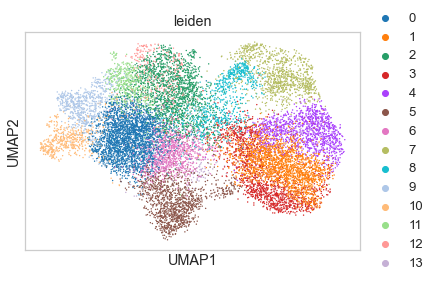

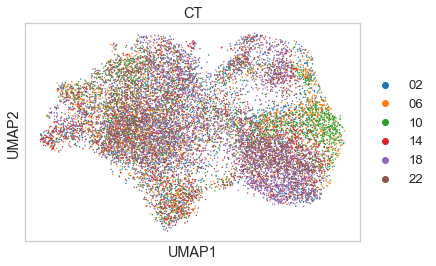

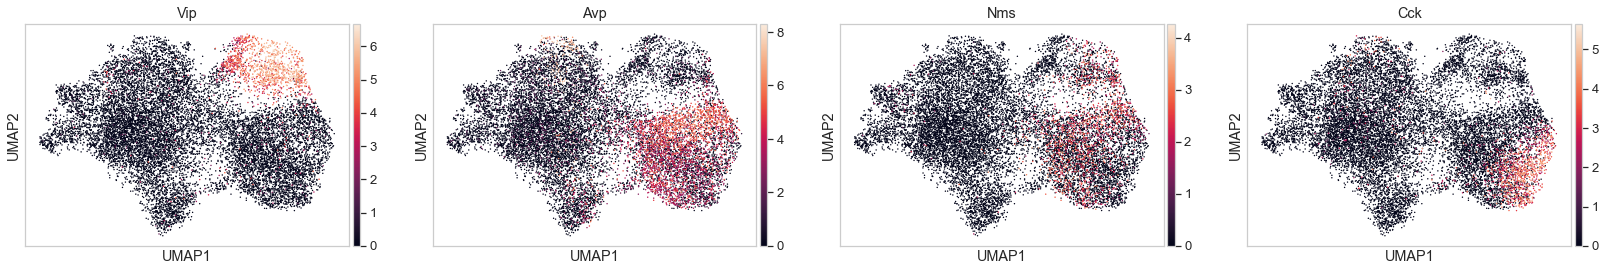

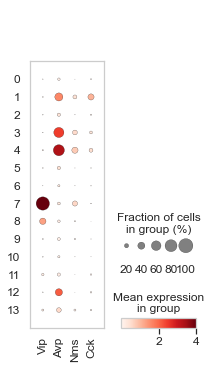

Cluster 0 contains 2490 samples
Cluster 1 contains 1969 samples
Cluster 2 contains 1675 samples
Cluster 3 contains 1306 samples
Cluster 4 contains 1239 samples
Cluster 5 contains 1237 samples
Cluster 6 contains 1016 samples
Cluster 7 contains 953 samples
Cluster 8 contains 758 samples
Cluster 9 contains 720 samples
Cluster 10 contains 505 samples
Cluster 11 contains 488 samples
Cluster 12 contains 293 samples
Cluster 13 contains 117 samples


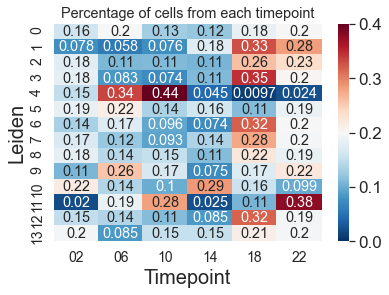

Mean variance: 0.7817096024159748
Mean entropy: 1.6647017167883582


In [52]:
sns.set_style("whitegrid")
sns.set_context(font_scale=1.5, rc={"lines.linewidth": 1.5})
sc.tl.pca(adata_neurons, svd_solver='arpack')
sc.pp.neighbors(adata_neurons, n_neighbors=10, n_pcs=40)
sc.tl.leiden(adata_neurons, resolution=1)
sc.tl.umap(adata_neurons)
sc.pl.umap(adata_neurons, color='leiden')# , title=("UMAP painted by louvain"))
sc.pl.umap(adata_neurons, color='CT')
sc.pl.umap(adata_neurons, color=marker_genes)
sns.set_style("whitegrid")
sns.set_context(font_scale=2, rc={"lines.linewidth": 1.5})
sc.pl.dotplot(adata_neurons, marker_genes, groupby='leiden', vmax=4,dot_max=1)
count_hours_per_cluster(adata_neurons, nclusters=14)

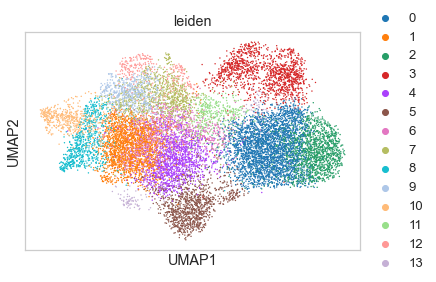

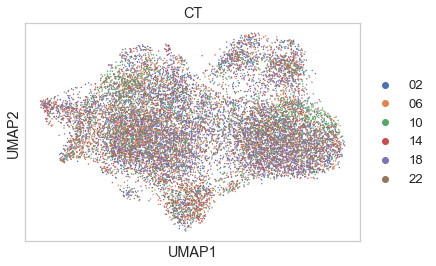

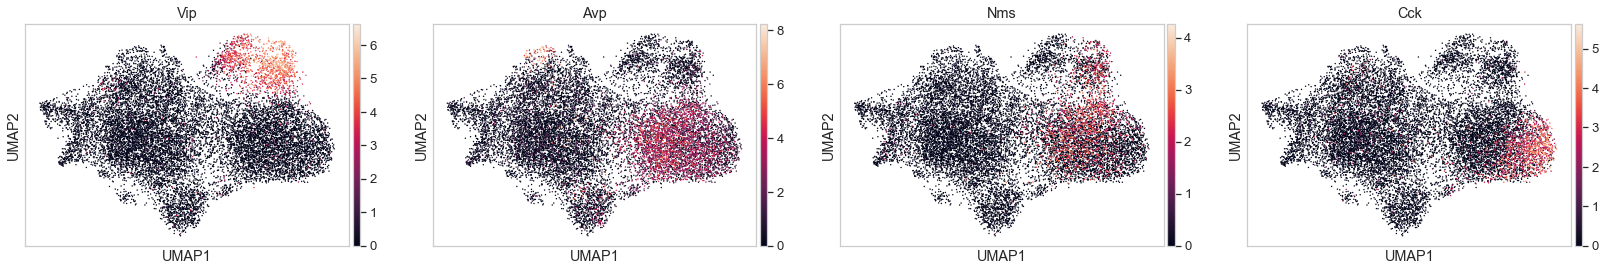

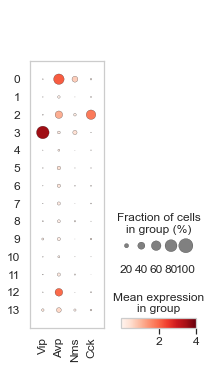

Cluster 0 contains 2962 samples
Cluster 1 contains 1922 samples
Cluster 2 contains 1458 samples
Cluster 3 contains 1326 samples
Cluster 4 contains 1291 samples
Cluster 5 contains 1112 samples
Cluster 6 contains 1024 samples
Cluster 7 contains 908 samples
Cluster 8 contains 715 samples
Cluster 9 contains 628 samples
Cluster 10 contains 535 samples
Cluster 11 contains 401 samples
Cluster 12 contains 345 samples
Cluster 13 contains 139 samples


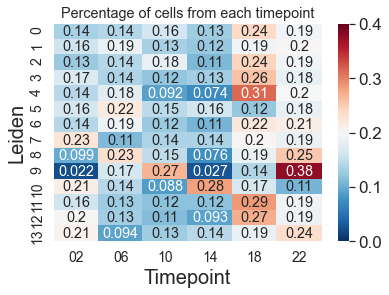

Mean variance: 0.8631765869597013
Mean entropy: 1.7239643054313152


In [69]:
sns.set_context(font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.set_style("whitegrid")
sc.tl.pca(adata_neurons_filtered, svd_solver='arpack')
sc.pp.neighbors(adata_neurons_filtered, n_neighbors=10, n_pcs=40)
sc.tl.leiden(adata_neurons_filtered, resolution=1)
sc.tl.umap(adata_neurons_filtered)
sc.pl.umap(adata_neurons_filtered, color='leiden')# , title=("UMAP painted by louvain"))
sc.pl.umap(adata_neurons_filtered, color='CT')
sc.pl.umap(adata_neurons_filtered, color=marker_genes)
sns.set_style("whitegrid")
sns.set_context(font_scale=1.5, rc={"lines.linewidth": 1.5})
sc.pl.dotplot(adata_neurons_filtered, marker_genes, groupby='leiden', vmax=4,dot_max=1)
count_hours_per_cluster(adata_neurons_filtered, nclusters=14)